## Imports

In [28]:
import json
import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, ValidationCurveDisplay
from sklearn.multioutput import MultiOutputRegressor

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import RandomUniform, RandomNormal, HeNormal, GlorotUniform, Constant, Zeros
from keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2


dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import grid_search, random_search, tuning_search_top_configs
from training.solver import Solver
from training.metrics import mean_euclidean_error as mee

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ensemble

## Settings

In [ ]:
MODEL_NAME = 'Ensemble'
INTERNAL_TEST_SPLIT = 0.1 # internal test split percentage
RANDOM_STATE = 128 # reproducibility
N_SPLITS = 5 # cross-validation
POLY_DEGREE = 3 # Polynomial features pre-processing

## Path

In [ ]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK

## Model: NN-SGD and NN-Adam

In [4]:
def get_nn_classifier( optimizer, hparams):
    initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
    
    model = Sequential([
        Dense(hparams['h_dim'], activation='tanh', input_shape=(17,), kernel_initializer=initializer),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(hparams['reg']))
    ])
       
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mse'])
    
    model.hparams = hparams
    return model

## Ensemble Majority Voting Schema

In [5]:
def ensemble_majority_voting(ensemble, svc_preds, nn_sgd_preds, nn_adam_preds):
    for i in range(len(ensemble)):
        if (svc_preds[i] + nn_sgd_preds[i] + nn_adam_preds[i]) > 1:
            ensemble[i] = 1
            
    return ensemble

## Ensemble Weigheted Voting Schema

In [6]:
# the weights used are the accuracy
def ensemble_weighted_voting(ensemble, svc_preds, nn_sgd_preds, nn_adam_preds, acc_svc, acc_nn_sgd, acc_nn_adam):
    for i in range(len(ensemble)):
        if (svc_preds[i]*acc_svc + nn_sgd_preds[i]*acc_nn_sgd + nn_adam_preds[i]*acc_nn_adam)/(acc_svc + acc_nn_sgd + acc_nn_adam) >= 0.5:
            ensemble[i] = 1
            
    return ensemble

## Ensemble Stacking Schema

In [7]:
def ensemble_stacking(svc_preds, nn_sgd_preds, nn_adam_preds):
    svc_preds = svc_preds.reshape(-1,1)
    x_stack = np.hstack((svc_preds, nn_sgd_preds, nn_adam_preds))
    clf = LogisticRegression(random_state=RANDOM_STATE)
    return clf, x_stack

## MONK-1

In [8]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

## Training 

In [9]:
# SVC Training
svc_m1 = SVC(C=10, degree=2, kernel='poly')
svc_m1.fit(x_dev_m1, y_dev_m1)

SVC(C=10, degree=2, kernel='poly')

In [10]:
# NN-SGD Training
hparams_sgd={'lr': 0.7, 'h_dim': 4, 'reg': 0.0}
optimizer_sgd = SGD(learning_rate=hparams_sgd['lr'])
nn_sgd_m1 = get_nn_classifier(optimizer_sgd, hparams_sgd)
solver_sgd = Solver(nn_sgd_m1, x_dev_m1, y_dev_m1, target='loss')
solver_sgd.train(epochs=300, patience=50, batch_size=len(x_dev_m1))

2024-01-24 01:09:28.446847: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/300
1/1 [==============================] - 0s 352ms/step - loss: 0.6823 - accuracy: 0.6048 - mse: 0.2445
Epoch 2/300
1/1 [==============================] - 0s 18ms/step - loss: 0.6597 - accuracy: 0.6129 - mse: 0.2338
Epoch 3/300
1/1 [==============================] - 0s 13ms/step - loss: 0.6435 - accuracy: 0.6290 - mse: 0.2260
Epoch 4/300
1/1 [==============================] - 0s 13ms/step - loss: 0.6295 - accuracy: 0.6694 - mse: 0.2193
Epoch 5/300
1/1 [==============================] - 0s 12ms/step - loss: 0.6168 - accuracy: 0.6855 - mse: 0.2133
Epoch 6/300
1/1 [==============================] - 0s 13ms/step - loss: 0.6048 - accuracy: 0.6855 - mse: 0.2076
Epoch 7/300
1/1 [==============================] - 0s 11ms/step - loss: 0.5935 - accuracy: 0.6935 - mse: 0.2024
Epoch 8/300
1/1 [==============================] - 0s 11ms/step - loss: 0.5827 - accuracy: 0.7097 - mse: 0.1974
Epoch 9/300
1/1 [==============================] - 0s 12ms/step - loss: 0.5723 - accuracy: 0.7258 - mse

In [11]:
# NN-Adam Training
hparams_adam={'lr': 0.3, 'h_dim': 4, 'reg': 0, 'beta_1': 0.9, 'beta_2': 0.9}
optimizer_adam = Adam(learning_rate=hparams_adam['lr'], beta_1=hparams_adam['beta_1'], beta_2=hparams_adam['beta_2'])
nn_adam_m1 = get_nn_classifier(optimizer_adam, hparams_adam)
solver_adam = Solver(nn_adam_m1, x_dev_m1, y_dev_m1, target='loss')
solver_adam.train(epochs=300, patience=50, batch_size=len(x_dev_m1))

Epoch 1/300
1/1 [==============================] - 0s 333ms/step - loss: 0.7197 - accuracy: 0.5000 - mse: 0.2621
Epoch 2/300
1/1 [==============================] - 0s 37ms/step - loss: 0.8254 - accuracy: 0.5000 - mse: 0.3056
Epoch 3/300
1/1 [==============================] - 0s 18ms/step - loss: 0.6093 - accuracy: 0.7016 - mse: 0.2093
Epoch 4/300
1/1 [==============================] - 0s 13ms/step - loss: 0.6782 - accuracy: 0.5000 - mse: 0.2448
Epoch 5/300
1/1 [==============================] - 0s 24ms/step - loss: 0.6547 - accuracy: 0.5000 - mse: 0.2335
Epoch 6/300
1/1 [==============================] - 0s 15ms/step - loss: 0.5711 - accuracy: 0.7500 - mse: 0.1928
Epoch 7/300
1/1 [==============================] - 0s 21ms/step - loss: 0.5308 - accuracy: 0.7258 - mse: 0.1748
Epoch 8/300
1/1 [==============================] - 0s 10ms/step - loss: 0.5300 - accuracy: 0.6774 - mse: 0.1781
Epoch 9/300
1/1 [==============================] - 0s 11ms/step - loss: 0.5006 - accuracy: 0.7016 - mse

## Ensemble - Training

In [12]:
# Prediction of each model
svc_m1_preds_dev = svc_m1.predict(x_dev_m1)
nn_sgd_m1_preds_dev = (np.rint(nn_sgd_m1.predict(x_dev_m1))).astype(int)
nn_adam_m1_preds_dev = (np.rint(nn_adam_m1.predict(x_dev_m1))).astype(int)

# Probability
#nn_sgd_m1_preds_dev = nn_sgd_m1.predict(x_dev_m1)
#nn_adam_m1_preds_dev = nn_adam_m1.predict(x_dev_m1)

4/4 [==============================] - 0s 9ms/step


In [13]:
# Accuracy of each model
acc_svc_m1_dev = accuracy_score(y_dev_m1, svc_m1_preds_dev)
acc_nn_sgd_m1_dev = nn_sgd_m1.evaluate(x_dev_m1, y_dev_m1)[1]
acc_nn_adam_m1_dev = nn_adam_m1.evaluate(x_dev_m1, y_dev_m1)[1]

4/4 [==============================] - 0s 14ms/step - loss: 3.4498e-08 - accuracy: 1.0000 - mse: 3.6398e-15


In [14]:
# Ensemble - Majority and Weighted Voting schema 
ensemble_dev = np.zeros(len(x_dev_m1), dtype=int)

en_maj_vot_dev = ensemble_majority_voting(ensemble_dev, 
                                          svc_m1_preds_dev, nn_sgd_m1_preds_dev, nn_adam_m1_preds_dev)

en_wei_vot_dev = ensemble_weighted_voting(ensemble_dev, 
                                          svc_m1_preds_dev, nn_sgd_m1_preds_dev, nn_adam_m1_preds_dev,
                                          acc_svc_m1_dev, acc_nn_sgd_m1_dev, acc_nn_sgd_m1_dev)

en_stack_dev, x_stack_dev = ensemble_stacking(svc_m1_preds_dev, nn_sgd_m1_preds_dev, nn_adam_m1_preds_dev)
en_stack_dev.fit(x_stack_dev, y_dev_m1)

LogisticRegression(random_state=128)

## Results Training

In [15]:
print('-- DEVELOPMENT Accuracy Models --')
print(f'Accuracy SVC: {acc_svc_m1_dev:.4f} - Accuracy NN-SGD: {acc_nn_sgd_m1_dev:.4f} - Accuracy NN-Adam: {acc_nn_adam_m1_dev:.4f}' )

print('\n-- DEVELOPMENT Majority Voting Schema --')
acc_dev_maj_m1 = accuracy_score(y_dev_m1, en_maj_vot_dev)
mse_dev_maj_m1 = mean_squared_error(y_dev_m1, en_maj_vot_dev)
print(f'Loss (MSE): {mse_dev_maj_m1:.4f} - Accuracy: {acc_dev_maj_m1:.4f}')

print('\n-- DEVELOPMENT Weighted Voting Schema --')
acc_dev_wei_m1 = accuracy_score(y_dev_m1, en_wei_vot_dev)
mse_dev_wei_m1 = mean_squared_error(y_dev_m1, en_wei_vot_dev)
print(f'Loss (MSE): {mse_dev_wei_m1:.4f} - Accuracy: {acc_dev_wei_m1:.4f}')

print('\n-- DEVELOPMENT Stacking Schema --')
acc_dev_stack_m1 = accuracy_score(y_dev_m1, en_stack_dev.predict(x_stack_dev))
mse_dev_stack_m1 = mean_squared_error(y_dev_m1, en_stack_dev.predict(x_stack_dev))
print(f'Loss (MSE): {mse_dev_stack_m1:.4f} - Accuracy: {acc_dev_stack_m1:.4f}')

-- DEVELOPMENT Accuracy Models --
Accuracy SVC: 1.0000 - Accuracy NN-SGD: 1.0000 - Accuracy NN-Adam: 1.0000

-- DEVELOPMENT Majority Voting Schema --
Loss (MSE): 0.0000 - Accuracy: 1.0000

-- DEVELOPMENT Weighted Voting Schema --
Loss (MSE): 0.0000 - Accuracy: 1.0000

-- DEVELOPMENT Stacking Schema --
Loss (MSE): 0.0000 - Accuracy: 1.0000


## Ensemble - Testing

In [16]:
# Prediction of each model
svc_m1_preds_test = svc_m1.predict(x_test_m1)
nn_sgd_m1_preds_test = (np.rint(nn_sgd_m1.predict(x_test_m1))).astype(int)
nn_adam_m1_preds_test = (np.rint(nn_adam_m1.predict(x_test_m1))).astype(int)

# Probability
#nn_sgd_m1_preds_test = nn_sgd_m1.predict(x_test_m1)
#nn_adam_m1_preds_test = nn_adam_m1.predict(x_test_m1)

14/14 [==============================] - 0s 2ms/step


In [17]:
# Accuracy of each model
acc_svc_m1_test = accuracy_score(y_test_m1, svc_m1_preds_test)
acc_nn_sgd_m1_test = nn_sgd_m1.evaluate(x_test_m1, y_test_m1)[1]
acc_nn_adam_m1_test = nn_adam_m1.evaluate(x_test_m1, y_test_m1)[1]

14/14 [==============================] - 0s 3ms/step - loss: 3.5582e-08 - accuracy: 1.0000 - mse: 3.8154e-15


In [18]:
# Ensemble - Majority and Weighted Voting schema
ensemble_test = np.zeros(len(x_test_m1), dtype=int)

en_maj_vot_test = ensemble_majority_voting(ensemble_test,
                                           svc_m1_preds_test, nn_sgd_m1_preds_test, nn_adam_m1_preds_test)

en_wei_vot_test = ensemble_weighted_voting(ensemble_test, 
                                          svc_m1_preds_test, nn_sgd_m1_preds_test, nn_adam_m1_preds_test,
                                          acc_svc_m1_test, acc_nn_sgd_m1_test, acc_nn_sgd_m1_test)

en_stack_test, x_stack_test = ensemble_stacking(svc_m1_preds_test, nn_sgd_m1_preds_test, nn_adam_m1_preds_test)
#en_stack_test.fit(x_stack_test, y_test_m1)                                    

## Results Test

In [19]:
print('-- TEST Accuracy Models--')
print(f'Accuracy SVC: {acc_svc_m1_test:.4f} - Accuracy NN-SGD: {acc_nn_sgd_m1_test:.4f} - Accuracy NN-Adam: {acc_nn_adam_m1_test:.4f}' )

print('\n-- TEST Majority Voting Schema--')
acc_test_maj_m1 = accuracy_score(y_test_m1, en_maj_vot_test)
mse_test_maj_m1 = mean_squared_error(y_test_m1, en_maj_vot_test)
print(f'Loss (MSE): {mse_test_maj_m1:.4f} - Accuracy: {acc_test_maj_m1:.4f}')

print('\n-- TEST Weighted Voting Schema--')
acc_test_wei_m1 = accuracy_score(y_test_m1, en_wei_vot_test)
mse_test_wei_m1 = mean_squared_error(y_test_m1, en_wei_vot_test)
print(f'Loss (MSE): {mse_test_wei_m1:.4f} - Accuracy: {acc_test_wei_m1:.4f}')

print('\n-- DEVELOPMENT Stacking Schema --')
acc_test_stack_m1 = accuracy_score(y_test_m1, en_stack_dev.predict(x_stack_test))
mse_test_stack_m1 = mean_squared_error(y_test_m1, en_stack_dev.predict(x_stack_test))
print(f'Loss (MSE): {mse_test_stack_m1:.4f} - Accuracy: {acc_test_stack_m1:.4f}')

-- TEST Accuracy Models--
Accuracy SVC: 1.0000 - Accuracy NN-SGD: 0.9907 - Accuracy NN-Adam: 1.0000

-- TEST Majority Voting Schema--
Loss (MSE): 0.0000 - Accuracy: 1.0000

-- TEST Weighted Voting Schema--
Loss (MSE): 0.0000 - Accuracy: 1.0000

-- DEVELOPMENT Stacking Schema --
Loss (MSE): 0.0000 - Accuracy: 1.0000


## Store results

In [20]:
report_m1 = {
    'dev_majority': {'accuracy': acc_dev_maj_m1, 'mse': mse_dev_maj_m1},
    'test_majority': {'accuracy': acc_test_maj_m1, 'mse': mse_test_maj_m1},
    'dev_weighted': {'accuracy': acc_dev_wei_m1, 'mse': mse_dev_wei_m1},
    'test_weighted': {'accuracy': acc_test_wei_m1, 'mse': mse_test_wei_m1},
    'dev_stacking': {'accuracy': acc_dev_stack_m1, 'mse': mse_dev_stack_m1},
    'test_stacking': {'accuracy': acc_test_stack_m1, 'mse': mse_test_stack_m1}
}

store_monk_result(results_dir + '/MONK1/', en_stack_dev.get_params(), report_m1)

## MONK-2

In [21]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

## Training 

In [22]:
# SVC Training
svc_m2 = SVC(C=50, degree=2, kernel='poly')
svc_m2.fit(x_dev_m2, y_dev_m2)

SVC(C=50, degree=2, kernel='poly')

In [23]:
# NN-SGD Training
hparams_sgd={'lr': 0.8, 'h_dim': 4, 'reg': 0}
optimizer_sgd = SGD(learning_rate=hparams_sgd['lr'])
nn_sgd_m2 = get_nn_classifier(optimizer_sgd, hparams_sgd)
solver_sgd = Solver(nn_sgd_m2, x_dev_m2, y_dev_m2, target='loss')
solver_sgd.train(epochs=300, patience=50, batch_size=len(x_dev_m2))

Epoch 1/300
1/1 [==============================] - 0s 269ms/step - loss: 0.6605 - accuracy: 0.6154 - mse: 0.2337
Epoch 2/300
1/1 [==============================] - 0s 35ms/step - loss: 0.6505 - accuracy: 0.6272 - mse: 0.2287
Epoch 3/300
1/1 [==============================] - 0s 16ms/step - loss: 0.6467 - accuracy: 0.6568 - mse: 0.2270
Epoch 4/300
1/1 [==============================] - 0s 16ms/step - loss: 0.6442 - accuracy: 0.6686 - mse: 0.2258
Epoch 5/300
1/1 [==============================] - 0s 16ms/step - loss: 0.6420 - accuracy: 0.6627 - mse: 0.2249
Epoch 6/300
1/1 [==============================] - 0s 16ms/step - loss: 0.6400 - accuracy: 0.6686 - mse: 0.2240
Epoch 7/300
1/1 [==============================] - 0s 16ms/step - loss: 0.6380 - accuracy: 0.6686 - mse: 0.2232
Epoch 8/300
1/1 [==============================] - 0s 16ms/step - loss: 0.6362 - accuracy: 0.6627 - mse: 0.2224
Epoch 9/300
1/1 [==============================] - 0s 13ms/step - loss: 0.6344 - accuracy: 0.6568 - mse

In [24]:
# NN-Adam Training
hparams_adam={'lr': 0.3, 'h_dim': 4, 'reg': 0, 'beta_1': 0.9, 'beta_2': 0.9}
optimizer_adam = Adam(learning_rate=hparams_adam['lr'], beta_1=hparams_adam['beta_1'], beta_2=hparams_adam['beta_2'])
nn_adam_m2 = get_nn_classifier(optimizer_adam, hparams_adam)
solver_adam = Solver(nn_adam_m2, x_dev_m2, y_dev_m2, target='loss')
solver_adam.train(epochs=300, patience=50, batch_size=len(x_dev_m2))

Epoch 1/300
1/1 [==============================] - 0s 303ms/step - loss: 0.8006 - accuracy: 0.4024 - mse: 0.3004
Epoch 2/300
1/1 [==============================] - 0s 9ms/step - loss: 0.6655 - accuracy: 0.6213 - mse: 0.2363
Epoch 3/300
1/1 [==============================] - 0s 8ms/step - loss: 0.7250 - accuracy: 0.3787 - mse: 0.2658
Epoch 4/300
1/1 [==============================] - 0s 7ms/step - loss: 0.6657 - accuracy: 0.6213 - mse: 0.2364
Epoch 5/300
1/1 [==============================] - 0s 10ms/step - loss: 0.6887 - accuracy: 0.6213 - mse: 0.2460
Epoch 6/300
1/1 [==============================] - 0s 9ms/step - loss: 0.7009 - accuracy: 0.6213 - mse: 0.2508
Epoch 7/300
1/1 [==============================] - 0s 9ms/step - loss: 0.6739 - accuracy: 0.6213 - mse: 0.2399
Epoch 8/300
1/1 [==============================] - 0s 11ms/step - loss: 0.6653 - accuracy: 0.6213 - mse: 0.2362
Epoch 9/300
1/1 [==============================] - 0s 10ms/step - loss: 0.6856 - accuracy: 0.6213 - mse: 0.2

## Ensemble - Training

In [25]:
# Prediction of each model
svc_m2_preds_dev = svc_m2.predict(x_dev_m2)
nn_sgd_m2_preds_dev = (np.rint(nn_sgd_m2.predict(x_dev_m2))).astype(int)
nn_adam_m2_preds_dev = (np.rint(nn_adam_m2.predict(x_dev_m2))).astype(int)

# Probability
#nn_sgd_m2_preds_dev = nn_sgd_m2.predict(x_dev_m2)
#nn_adam_m2_preds_dev = nn_adam_m2.predict(x_dev_m2)

6/6 [==============================] - 0s 7ms/step


In [26]:
# Accuracy of each model
acc_svc_m2_dev = accuracy_score(y_dev_m2, svc_m2_preds_dev)
acc_nn_sgd_m2_dev = nn_sgd_m2.evaluate(x_dev_m2, y_dev_m2)[1]
acc_nn_adam_m2_dev = nn_adam_m2.evaluate(x_dev_m2, y_dev_m2)[1]

6/6 [==============================] - 0s 8ms/step - loss: 0.6663 - accuracy: 0.6213 - mse: 0.2366


In [27]:
# Ensemble - Majority and Weighted Voting schema 
ensemble_dev = np.zeros(len(x_dev_m2), dtype=int)

en_maj_vot_dev = ensemble_majority_voting(ensemble_dev, 
                                          svc_m2_preds_dev, nn_sgd_m2_preds_dev, nn_adam_m2_preds_dev)

en_wei_vot_dev = ensemble_weighted_voting(ensemble_dev, 
                                          svc_m2_preds_dev, nn_sgd_m2_preds_dev, nn_adam_m2_preds_dev,
                                          acc_svc_m2_dev, acc_nn_sgd_m2_dev, acc_nn_sgd_m2_dev)

en_stack_dev, x_stack_dev = ensemble_stacking(svc_m2_preds_dev, nn_sgd_m2_preds_dev, nn_adam_m2_preds_dev)
en_stack_dev.fit(x_stack_dev, y_dev_m2)
                                          

LogisticRegression(random_state=128)

## Results Training

In [28]:
print('-- DEVELOPMENT Accuracy Models --')
print(f'Accuracy SVC: {acc_svc_m2_dev:.4f} - Accuracy NN-SGD: {acc_nn_sgd_m2_dev:.4f} - Accuracy NN-Adam: {acc_nn_adam_m2_dev:.4f}' )

print('\n-- DEVELOPMENT Majority Voting Schema --')
acc_dev_maj_m2 = accuracy_score(y_dev_m2, en_maj_vot_dev)
mse_dev_maj_m2 = mean_squared_error(y_dev_m2, en_maj_vot_dev)
print(f'Loss (MSE): {mse_dev_maj_m2:.4f} - Accuracy: {acc_dev_maj_m2:.4f}')

print('\n-- DEVELOPMENT Weighted Voting Schema --')
acc_dev_wei_m2 = accuracy_score(y_dev_m2, en_wei_vot_dev)
mse_dev_wei_m2 = mean_squared_error(y_dev_m2, en_wei_vot_dev)
print(f'Loss (MSE): {mse_dev_wei_m2:.4f} - Accuracy: {acc_dev_wei_m2:.4f}')

print('\n-- DEVELOPMENT Stacking Schema --')
acc_dev_stack_m2 = accuracy_score(y_dev_m2, en_stack_dev.predict(x_stack_dev))
mse_dev_stack_m2 = mean_squared_error(y_dev_m2, en_stack_dev.predict(x_stack_dev))
print(f'Loss (MSE): {mse_dev_stack_m2:.4f} - Accuracy: {acc_dev_stack_m2:.4f}')

-- DEVELOPMENT Accuracy Models --
Accuracy SVC: 1.0000 - Accuracy NN-SGD: 1.0000 - Accuracy NN-Adam: 0.6213

-- DEVELOPMENT Majority Voting Schema --
Loss (MSE): 0.0000 - Accuracy: 1.0000

-- DEVELOPMENT Weighted Voting Schema --
Loss (MSE): 0.0000 - Accuracy: 1.0000

-- DEVELOPMENT Stacking Schema --
Loss (MSE): 0.0000 - Accuracy: 1.0000


## Ensemble - Testing

In [29]:
# Prediction of each model
svc_m2_preds_test = svc_m2.predict(x_test_m2)
nn_sgd_m2_preds_test = (np.rint(nn_sgd_m2.predict(x_test_m2))).astype(int)
nn_adam_m2_preds_test = (np.rint(nn_adam_m2.predict(x_test_m2))).astype(int)

# Probability
#nn_sgd_m2_preds_test = nn_sgd_m2.predict(x_test_m2)
#nn_adam_m2_preds_test = nn_adam_m2.predict(x_test_m2)

14/14 [==============================] - 0s 6ms/step


In [30]:
# Accuracy of each model
acc_svc_m2_test = accuracy_score(y_test_m2, svc_m2_preds_test)
acc_nn_sgd_m2_test = nn_sgd_m2.evaluate(x_test_m2, y_test_m2)[1]
acc_nn_adam_m2_test = nn_adam_m2.evaluate(x_test_m2, y_test_m2)[1]

14/14 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.6713 - mse: 0.2208


In [31]:
# Ensemble - Majority and Weighted Voting schema
ensemble_test = np.zeros(len(x_test_m2), dtype=int)

en_maj_vot_test = ensemble_majority_voting(ensemble_test,
                                           svc_m2_preds_test, nn_sgd_m2_preds_test, nn_adam_m2_preds_test)

en_wei_vot_test = ensemble_weighted_voting(ensemble_test, 
                                          svc_m2_preds_test, nn_sgd_m2_preds_test, nn_adam_m2_preds_test,
                                          acc_svc_m2_test, acc_nn_sgd_m2_test, acc_nn_sgd_m2_test)

en_stack_test, x_stack_test = ensemble_stacking(svc_m2_preds_test, nn_sgd_m2_preds_test, nn_adam_m2_preds_test)
#en_stack_test.fit(x_stack_test, y_test_m2)                                          

## Results Test

In [32]:
print('-- TEST Accuracy Models--')
print(f'Accuracy SVC: {acc_svc_m2_test:.4f} - Accuracy NN-SGD: {acc_nn_sgd_m2_test:.4f} - Accuracy NN-Adam: {acc_nn_adam_m2_test:.4f}' )

print('\n-- TEST Majority Voting Schema--')
acc_test_maj_m2 = accuracy_score(y_test_m2, en_maj_vot_test)
mse_test_maj_m2 = mean_squared_error(y_test_m2, en_maj_vot_test)
print(f'Loss (MSE): {mse_test_maj_m2:.4f} - Accuracy: {acc_test_maj_m2:.4f}')

print('\n-- TEST Weighted Voting Schema--')
acc_test_wei_m2 = accuracy_score(y_test_m2, en_wei_vot_test)
mse_test_wei_m2 = mean_squared_error(y_test_m2, en_wei_vot_test)
print(f'Loss (MSE): {mse_test_wei_m2:.4f} - Accuracy: {acc_test_wei_m2:.4f}')

print('\n-- DEVELOPMENT Stacking Schema --')
acc_test_stack_m2 = accuracy_score(y_test_m2, en_stack_dev.predict(x_stack_test))
mse_test_stack_m2 = mean_squared_error(y_test_m2, en_stack_dev.predict(x_stack_test))
print(f'Loss (MSE): {mse_test_stack_m2:.4f} - Accuracy: {acc_test_stack_m2:.4f}')

-- TEST Accuracy Models--
Accuracy SVC: 1.0000 - Accuracy NN-SGD: 1.0000 - Accuracy NN-Adam: 0.6713

-- TEST Majority Voting Schema--
Loss (MSE): 0.0000 - Accuracy: 1.0000

-- TEST Weighted Voting Schema--
Loss (MSE): 0.0000 - Accuracy: 1.0000

-- DEVELOPMENT Stacking Schema --
Loss (MSE): 0.0000 - Accuracy: 1.0000


## Store results

In [33]:
report_m2 = {
    'dev_majority': {'accuracy': acc_dev_maj_m2, 'mse': mse_dev_maj_m2},
    'test_majority': {'accuracy': acc_test_maj_m2, 'mse': mse_test_maj_m2},
    'dev_weighted': {'accuracy': acc_dev_wei_m2, 'mse': mse_dev_wei_m2},
    'test_weighted': {'accuracy': acc_test_wei_m2, 'mse': mse_test_wei_m2},
    'dev_stacking': {'accuracy': acc_dev_stack_m2, 'mse': mse_dev_stack_m2},
    'test_stacking': {'accuracy': acc_test_stack_m2, 'mse': mse_test_stack_m2}
}

store_monk_result(results_dir + '/MONK2/', en_stack_dev.get_params(), report_m2)

## MONK-3

In [34]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

## Training

In [35]:
# SVC Training
svc_m3 = SVC(C=10, degree=2, gamma='auto', kernel='poly')
svc_m3.fit(x_dev_m3, y_dev_m3)

SVC(C=10, degree=2, gamma='auto', kernel='poly')

In [36]:
# NN-SGD Training
hparams_sgd={'lr': 0.6, 'h_dim': 4, 'reg': 0.001}
optimizer_sgd = SGD(learning_rate=hparams_sgd['lr'])
nn_sgd_m3 = get_nn_classifier(optimizer_sgd, hparams_sgd)
solver_sgd = Solver(nn_sgd_m3, x_dev_m3, y_dev_m3, target='loss')
solver_sgd.train(epochs=300, patience=50, batch_size=len(x_dev_m3))

Epoch 1/300
1/1 [==============================] - 0s 270ms/step - loss: 0.6720 - accuracy: 0.6557 - mse: 0.2392
Epoch 2/300
1/1 [==============================] - 0s 17ms/step - loss: 0.6583 - accuracy: 0.6721 - mse: 0.2324
Epoch 3/300
1/1 [==============================] - 0s 18ms/step - loss: 0.6444 - accuracy: 0.7295 - mse: 0.2255
Epoch 4/300
1/1 [==============================] - 0s 21ms/step - loss: 0.6298 - accuracy: 0.7951 - mse: 0.2183
Epoch 5/300
1/1 [==============================] - 0s 21ms/step - loss: 0.6143 - accuracy: 0.8033 - mse: 0.2106
Epoch 6/300
1/1 [==============================] - 0s 11ms/step - loss: 0.5975 - accuracy: 0.8115 - mse: 0.2024
Epoch 7/300
1/1 [==============================] - 0s 9ms/step - loss: 0.5796 - accuracy: 0.8197 - mse: 0.1938
Epoch 8/300
1/1 [==============================] - 0s 10ms/step - loss: 0.5606 - accuracy: 0.8361 - mse: 0.1846
Epoch 9/300
1/1 [==============================] - 0s 13ms/step - loss: 0.5406 - accuracy: 0.8607 - mse:

In [37]:
# NN-Adam Training
hparams_adam={'lr': 0.3, 'h_dim': 4, 'reg': 0.02, 'beta_1': 0.9, 'beta_2': 0.9}
optimizer_adam = Adam(learning_rate=hparams_adam['lr'], beta_1=hparams_adam['beta_1'], beta_2=hparams_adam['beta_2'])
nn_adam_m3 = get_nn_classifier(optimizer_adam, hparams_adam)
solver_adam = Solver(nn_adam_m3, x_dev_m3, y_dev_m3, target='loss')
solver_adam.train(epochs=300, patience=50, batch_size=len(x_dev_m3))

Epoch 1/300
1/1 [==============================] - 0s 308ms/step - loss: 0.6830 - accuracy: 0.6230 - mse: 0.2300
Epoch 2/300
1/1 [==============================] - 0s 10ms/step - loss: 0.6561 - accuracy: 0.5902 - mse: 0.2252
Epoch 3/300
1/1 [==============================] - 0s 26ms/step - loss: 0.5538 - accuracy: 0.7377 - mse: 0.1761
Epoch 4/300
1/1 [==============================] - 0s 14ms/step - loss: 0.5137 - accuracy: 0.7459 - mse: 0.1609
Epoch 5/300
1/1 [==============================] - 0s 14ms/step - loss: 0.4058 - accuracy: 0.8689 - mse: 0.1125
Epoch 6/300
1/1 [==============================] - 0s 9ms/step - loss: 0.3240 - accuracy: 0.9344 - mse: 0.0764
Epoch 7/300
1/1 [==============================] - 0s 20ms/step - loss: 0.3068 - accuracy: 0.9262 - mse: 0.0683
Epoch 8/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2996 - accuracy: 0.9262 - mse: 0.0610
Epoch 9/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2899 - accuracy: 0.9426 - mse: 0

## Ensamble Training

In [38]:
# Prediction of each model
svc_m3_preds_dev = svc_m3.predict(x_dev_m3)
nn_sgd_m3_preds_dev = (np.rint(nn_sgd_m3.predict(x_dev_m3))).astype(int)
nn_adam_m3_preds_dev = (np.rint(nn_adam_m3.predict(x_dev_m3))).astype(int)

# Probability
#nn_sgd_m3_preds_dev = nn_sgd_m3.predict(x_dev_m3)
#nn_adam_m3_preds_dev = nn_adam_m3.predict(x_dev_m3)

4/4 [==============================] - 0s 7ms/step


In [39]:
# Accuracy of each model
acc_svc_m3_dev = accuracy_score(y_dev_m3, svc_m3_preds_dev)
acc_nn_sgd_m3_dev = nn_sgd_m3.evaluate(x_dev_m3, y_dev_m3)[1]
acc_nn_adam_m3_dev = nn_adam_m3.evaluate(x_dev_m3, y_dev_m3)[1]

4/4 [==============================] - 0s 13ms/step - loss: 0.1567 - accuracy: 0.9754 - mse: 0.0213


In [40]:
# Ensemble - Majority and Weighted Voting schema 
ensemble_dev = np.zeros(len(x_dev_m3), dtype=int)

en_maj_vot_dev = ensemble_majority_voting(ensemble_dev, 
                                          svc_m3_preds_dev, nn_sgd_m3_preds_dev, nn_adam_m3_preds_dev)

en_wei_vot_dev = ensemble_weighted_voting(ensemble_dev, 
                                          svc_m3_preds_dev, nn_sgd_m3_preds_dev, nn_adam_m3_preds_dev,
                                          acc_svc_m3_dev, acc_nn_sgd_m3_dev, acc_nn_sgd_m3_dev)

en_stack_dev, x_stack_dev = ensemble_stacking(svc_m3_preds_dev, nn_sgd_m3_preds_dev, nn_adam_m3_preds_dev)
en_stack_dev.fit(x_stack_dev, y_dev_m3)
                                              

LogisticRegression(random_state=128)

## Result Training

In [41]:
print('-- DEVELOPMENT Accuracy Models --')
print(f'Accuracy SVC: {acc_svc_m3_dev:.4f} - Accuracy NN-SGD: {acc_nn_sgd_m3_dev:.4f} - Accuracy NN-Adam: {acc_nn_adam_m3_dev:.4f}' )

print('\n-- DEVELOPMENT Majority Voting Schema --')
acc_dev_maj_m3 = accuracy_score(y_dev_m3, en_maj_vot_dev)
mse_dev_maj_m3 = mean_squared_error(y_dev_m3, en_maj_vot_dev)
print(f'Loss (MSE): {mse_dev_maj_m3:.4f} - Accuracy: {acc_dev_maj_m3:.4f}')

print('\n-- DEVELOPMENT Weighted Voting Schema --')
acc_dev_wei_m3 = accuracy_score(y_dev_m3, en_wei_vot_dev)
mse_dev_wei_m3 = mean_squared_error(y_dev_m3, en_wei_vot_dev)
print(f'Loss (MSE): {mse_dev_wei_m3:.4f} - Accuracy: {acc_dev_wei_m3:.4f}')

print('\n-- DEVELOPMENT Stacking Schema --')
acc_dev_stack_m3 = accuracy_score(y_dev_m3, en_stack_dev.predict(x_stack_dev))
mse_dev_stack_m3 = mean_squared_error(y_dev_m3, en_stack_dev.predict(x_stack_dev))
print(f'Loss (MSE): {mse_dev_stack_m3:.4f} - Accuracy: {acc_dev_stack_m3:.4f}')

-- DEVELOPMENT Accuracy Models --
Accuracy SVC: 0.9344 - Accuracy NN-SGD: 0.9754 - Accuracy NN-Adam: 0.9754

-- DEVELOPMENT Majority Voting Schema --
Loss (MSE): 0.0328 - Accuracy: 0.9672

-- DEVELOPMENT Weighted Voting Schema --
Loss (MSE): 0.0328 - Accuracy: 0.9672

-- DEVELOPMENT Stacking Schema --
Loss (MSE): 0.0328 - Accuracy: 0.9672


## Ensamble Test

In [42]:
# Prediction of each model
svc_m3_preds_test = svc_m3.predict(x_test_m3)
nn_sgd_m3_preds_test = (np.rint(nn_sgd_m3.predict(x_test_m3))).astype(int)
nn_adam_m3_preds_test = (np.rint(nn_adam_m3.predict(x_test_m3))).astype(int)

# Probability
#nn_sgd_m3_preds_test = nn_sgd_m3.predict(x_test_m3)
#nn_adam_m3_preds_test = nn_adam_m3.predict(x_test_m3)

14/14 [==============================] - 0s 2ms/step


In [43]:
# Accuracy of each model
acc_svc_m3_test = accuracy_score(y_test_m3, svc_m3_preds_test)
acc_nn_sgd_m3_test = nn_sgd_m3.evaluate(x_test_m3, y_test_m3)[1]
acc_nn_adam_m3_test = nn_adam_m3.evaluate(x_test_m3, y_test_m3)[1]

14/14 [==============================] - 0s 4ms/step - loss: 0.1822 - accuracy: 0.9491 - mse: 0.0341


In [44]:
# Ensemble - Majority and Weighted Voting schemaR
ensemble_test = np.zeros(len(x_test_m3), dtype=int)

en_maj_vot_test = ensemble_majority_voting(ensemble_test,
                                           svc_m3_preds_test, nn_sgd_m3_preds_test, nn_adam_m3_preds_test)

en_wei_vot_test = ensemble_weighted_voting(ensemble_test, 
                                          svc_m3_preds_test, nn_sgd_m3_preds_test, nn_adam_m3_preds_test,
                                          acc_svc_m3_test, acc_nn_sgd_m3_test, acc_nn_sgd_m3_test)

en_stack_test, x_stack_test = ensemble_stacking(svc_m3_preds_test, nn_sgd_m3_preds_test, nn_adam_m3_preds_test)
#en_stack_test.fit(x_stack_test, y_test_m3)                                          

## Results Test

In [45]:
print('-- TEST Accuracy Models--')
print(f'Accuracy SVC: {acc_svc_m3_test:.4f} - Accuracy NN-SGD: {acc_nn_sgd_m3_test:.4f} - Accuracy NN-Adam: {acc_nn_adam_m3_test:.4f}' )

print('\n-- TEST Majority Voting Schema--')
acc_test_maj_m3 = accuracy_score(y_test_m3, en_maj_vot_test)
mse_test_maj_m3 = mean_squared_error(y_test_m3, en_maj_vot_test)
print(f'Loss (MSE): {mse_test_maj_m3:.4f} - Accuracy: {acc_test_maj_m3:.4f}')

print('\n-- TEST Weighted Voting Schema--')
acc_test_wei_m3 = accuracy_score(y_test_m3, en_wei_vot_test)
mse_test_wei_m3 = mean_squared_error(y_test_m3, en_wei_vot_test)
print(f'Loss (MSE): {mse_test_wei_m3:.4f} - Accuracy: {acc_test_wei_m3:.4f}')

print('\n-- DEVELOPMENT Stacking Schema --')
acc_test_stack_m3 = accuracy_score(y_test_m3, en_stack_dev.predict(x_stack_test))
mse_test_stack_m3 = mean_squared_error(y_test_m3, en_stack_dev.predict(x_stack_test))
print(f'Loss (MSE): {mse_test_stack_m3:.4f} - Accuracy: {acc_test_stack_m3:.4f}')

-- TEST Accuracy Models--
Accuracy SVC: 0.9722 - Accuracy NN-SGD: 0.9630 - Accuracy NN-Adam: 0.9491

-- TEST Majority Voting Schema--
Loss (MSE): 0.0440 - Accuracy: 0.9560

-- TEST Weighted Voting Schema--
Loss (MSE): 0.0440 - Accuracy: 0.9560

-- DEVELOPMENT Stacking Schema --
Loss (MSE): 0.0440 - Accuracy: 0.9560


## Store results

In [46]:
report_m3 = {
    'dev_majority': {'accuracy': acc_dev_maj_m3, 'mse': mse_dev_maj_m3},
    'test_majority': {'accuracy': acc_test_maj_m3, 'mse': mse_test_maj_m3},
    'dev_weighted': {'accuracy': acc_dev_wei_m3, 'mse': mse_dev_wei_m3},
    'test_weighted': {'accuracy': acc_test_wei_m3, 'mse': mse_test_wei_m3},
    'dev_stacking': {'accuracy': acc_dev_stack_m3, 'mse': mse_dev_stack_m3},
    'test_stacking': {'accuracy': acc_test_stack_m3, 'mse': mse_test_stack_m3}
}

store_monk_result(results_dir + '/MONK3/', en_stack_dev.get_params(), report_m3)

# Ensemble - CUP

In [12]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

In [23]:
@keras.utils.register_keras_serializable()
def mean_euclidean_error(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Utility function to compute the Mean Euclidean Error (MEE) between 
    true and predicted values for a tensorflow model. 
    Return the MEE score as a tensor.

    Required arguments:
    - y_true: array containing true values (ground truth).
    - y_pred: array containing predicted values.
    """
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=-1)))

## Dev - Internal Test Split 
The development dataset is split between training and internal test ($90-10$).

In [14]:
# Split dev data into train - internal test
x_train_cup, x_internal_test_cup, y_train_cup, y_internal_test_cup = train_test_split(
    x_dev_cup, 
    y_dev_cup, 
    test_size=INTERNAL_TEST_SPLIT, 
    random_state=RANDOM_STATE
)

## Polynomial features
We create a version of our dataset to which PolynoMialFeatures pre-processing is applied with a fixed degree.

In [15]:
# Polynomial features pre-processing
poly = PolynomialFeatures(degree=POLY_DEGREE) # Polynomial features pre-processing
x_train_cup_poly = poly.fit_transform(x_train_cup)
x_internal_test_cup_poly = poly.transform(x_internal_test_cup)

## Models and Ensemles - Regression

In [50]:
def get_nn_regressor(optimizer, hparams):
    if hparams['activation'] == 'tanh':
        initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
        bias_initializer = Zeros()
    elif hparams['activation'] == 'ReLU':
        initializer = HeNormal(seed=RANDOM_STATE) # He (Kaiming)
        bias_initializer = Constant(0.1)
        
    reg = l2(hparams['reg'])
        
    model = Sequential()
    model.add(Dense(
        hparams['h_dim'], 
        activation=hparams['activation'], 
        input_shape=(10,), 
        kernel_regularizer=l2(hparams['reg']),
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    h_dim = hparams['h_dim']
    for i in range(hparams['n_layers'] - 1):
        model.add(
            Dense(
                h_dim, 
                activation=hparams['activation'],
                kernel_regularizer=l2(hparams['reg']),
                kernel_initializer=initializer,
                bias_initializer=bias_initializer))
        h_dim //= 2

    model.add(Dense(
        3, 
        activation='linear', 
        kernel_regularizer=l2(hparams['reg']), 
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    model.compile(optimizer=optimizer, loss='mse', metrics=[mean_euclidean_error])
    return model

## Ensemble Arithmetic Averange

In [51]:
def ensemble_arithmetic_averange(ensemble, svr_preds, nn_sgd_preds, nn_adam_preds):
    #for i, j in ensemble.shape:
        #ensemble[i][j] = (svr_preds[i][j] + nn_sgd_preds[i][j]+ nn_adam_preds[i][j])/3 
            
    return (svr_preds + nn_sgd_preds + nn_adam_preds)/3 

## Ensemble Weighted Averange

In [52]:
# the weight used is (N - mee)
def ensemble_weighted_averange(ensemble, N, svr_preds, nn_sgd_preds, nn_adam_preds, mee_svr, mee_nn_sgd, mee_nn_adam):
    
    if (N < mee_svr or N < mee_nn_sgd or N < mee_nn_adam):
        raise ValueError("N must be greater than mee")
        
    #for i in range(len(ensemble)):
    #    ensemble[i] = svc_preds[i]*(N-mee_svr) + nn_sgd_preds[i]*(N-mee_nn_sgd) + nn_adam_preds[i]*(N-mee_nn_adam)/(3*N - (mee_svr + mee_nn_sgd + mee_nn_adam))
            
    return (svr_preds*(N-mee_svr) + nn_sgd_preds*(N-mee_nn_sgd) + nn_adam_preds*(N-mee_nn_adam))/(3*N - (mee_svr + mee_nn_sgd + mee_nn_adam))

## Ensemble Stacking 

In [78]:
def ensemble_stacking_cup(estimator):
    if(estimator == 'LinearRegression'): ensemble = LinearRegression()
    elif(estimator == 'Ridge'): ensemble = Ridge()
    elif(estimator == 'Lasso'): ensemble = Lasso(alpha=0.035)
    else: raise ValueError("Estimator not valid")
    return ensemble

## Training

In [54]:
# SVR Traning
multi_svr = MultiOutputRegressor(SVR(C=2000, epsilon=0.07, kernel='rbf', gamma='scale'))
multi_svr.fit(x_train_cup, y_train_cup)

MultiOutputRegressor(estimator=SVR(C=2000, epsilon=0.07))

In [ ]:
# NN-SGD Training
best_config_sgd_cup = {
    'lr': 0.00035,
    'h_dim': 100,
    'n_layers': 3,
    'activation': 'tanh',
    'reg': 0.001,
    'momentum': 0.95, 
    'batch_size': 32,
}

optimizer_sgd = SGD(learning_rate=best_config_sgd_cup['lr'], momentum=best_config_sgd_cup['momentum'])
model_nn_sgd_cup = get_nn_regressor(optimizer_sgd, best_config_sgd_cup)
solver_sgd = Solver(model_nn_sgd_cup, x_train_cup, y_train_cup, x_internal_test_cup, y_internal_test_cup, target='mean_euclidean_error')
solver_sgd.train(epochs=1500, patience=100)

In [ ]:
best_config_adam_cup = {
    'lr': 0.001,
    'h_dim': 64,
    'n_layers': 2,
    'activation': 'tanh',
    'reg': 0.001,
    'beta_1': 0.9,
    'beta_2': 0.99,
    'batch_size': 32,
}

optimizer_adam = Adam(learning_rate=best_config_adam_cup['lr'], beta_1=best_config_adam_cup['beta_1'], beta_2=best_config_adam_cup['beta_2'])
model_nn_adam_cup = get_nn_regressor(optimizer_adam, best_config_adam_cup)
solver_adam = Solver(model_nn_adam_cup, x_train_cup, y_train_cup, x_internal_test_cup, y_internal_test_cup, target='mean_euclidean_error')
solver_adam.train(epochs=1500, patience=100)

# Ensamble Training

In [57]:
# Prediction of each model
svr_preds_train = multi_svr.predict(x_train_cup)
nn_sgd_preds_train = model_nn_sgd_cup.predict(x_train_cup)
nn_adam_preds_train = model_nn_adam_cup.predict(x_train_cup)

29/29 [==============================] - 0s 2ms/step


In [58]:
# MEE of each model
mee_svr_train = mee(y_train_cup, svr_preds_train)
mee_nn_sgd_train = model_nn_sgd_cup.evaluate(x_train_cup, y_train_cup)[1]
mee_nn_adam_train = model_nn_adam_cup.evaluate(x_train_cup, y_train_cup)[1]

29/29 [==============================] - 0s 4ms/step - loss: 0.5887 - mean_euclidean_error: 0.4227


In [81]:
# Ensemble Arithmetic and Weighted Averange
ensemble_train = np.zeros(y_train_cup.shape)

en_av_train = ensemble_arithmetic_averange(ensemble_train, svr_preds_train, nn_sgd_preds_train, nn_adam_preds_train)

en_we_train = ensemble_weighted_averange(ensemble_train, 1,
                                       svr_preds_train, nn_sgd_preds_train, nn_adam_preds_train,
                                       mee_svr_train, mee_nn_sgd_train, mee_nn_adam_train)

# Ensemble Stacking. Valid estimator: LinearRegression, Ridge or Lasso
en_stack_train = ensemble_stacking_cup(estimator='LinearRegression')
x_stack_cup_train = np.hstack((svr_preds_train, nn_sgd_preds_train, nn_adam_preds_train))
en_stack_train.fit(x_stack_cup_train, y_train_cup)

LinearRegression()

## Hyper-parameters Tuning for Stacking Ensamble
ValidationCurveDisplay is used to identify which of the three models: LinearRegression, Ridge or Lasso have lower error as alpha changes.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.7s finished


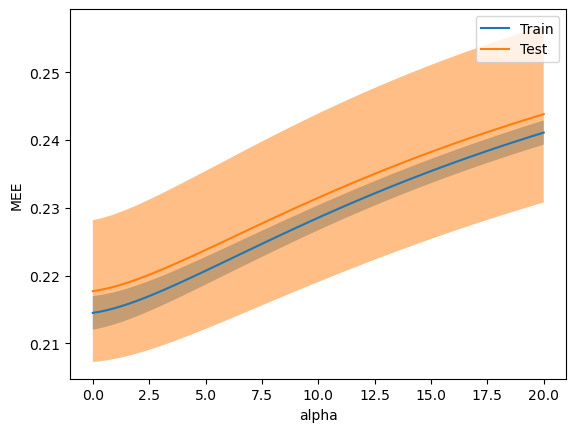

In [60]:
param_name = "alpha"
param_range = np.linspace(0, 20, 100)

ValidationCurveDisplay.from_estimator(Ridge(), 
                                      x_stack_cup_train, 
                                      y_train_cup, 
                                      param_name=param_name, 
                                      param_range=param_range,
                                      cv=KFold(n_splits=5, shuffle=True, random_state=128),
                                      scoring= make_scorer(mee, greater_is_better = False),
                                      negate_score = True,
                                      score_name="MEE",
                                      verbose=1)

plt.show()

The curve is monotonically increasing, the best alpha is 0. Ridge(alpha=0) = LinearRegressor()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.0s finished


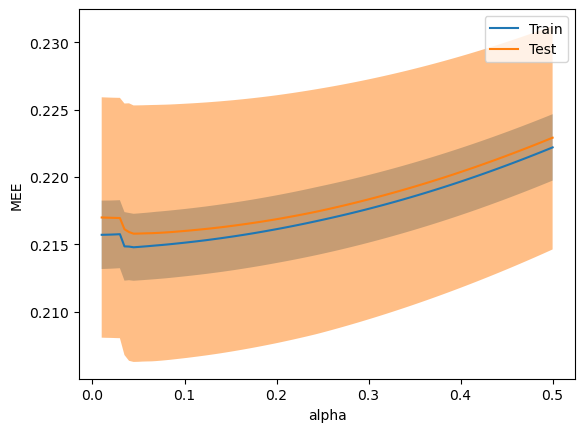

In [77]:
param_name = "alpha"
param_range = np.linspace(0.01, 0.5, 100)

ValidationCurveDisplay.from_estimator(Lasso(), 
                                      x_stack_cup_train, 
                                      y_train_cup, 
                                      param_name=param_name, 
                                      param_range=param_range,
                                      cv=KFold(n_splits=5, shuffle=True, random_state=128),
                                      scoring= make_scorer(mee, greater_is_better = False),
                                      negate_score = True,
                                      score_name="MEE",
                                      verbose=1)

plt.show()

## Training Results

In [62]:
print('-- DEVELOPMENT MEE Models --')
print(f'MEE SVC: {mee_svr_train:.4f} - MEE NN-SGD: {mee_nn_sgd_train:.4f} - MEE NN-Adam: {mee_nn_adam_train:.4f}' )

print('\n-- DEVELOPMENT Arithmetic Averange--')
mee_train_av_cup = mee(y_train_cup, en_av_train)
mse_train_av_cup = mean_squared_error(y_train_cup, en_av_train)
print(f'Loss (MSE): {mse_train_av_cup:.4f} - MEE: {mee_train_av_cup:.4f}')

print('\n-- DEVELOPMENT Weighted Averange --')
mee_train_we_cup = mee(y_train_cup, en_we_train)
mse_train_we_cup = mean_squared_error(y_train_cup, en_we_train)
print(f'Loss (MSE): {mse_train_we_cup:.4f} - MEE: {mee_train_we_cup:.4f}')

print('\n-- DEVELOPMENT Stacking Schema --')
mee_train_stack_cup = mee(y_train_cup, en_stack_train.predict(x_stack_cup_train))
mse_train_stack_cup = mean_squared_error(y_train_cup, en_stack_train.predict(x_stack_cup_train))
print(f'Loss (MSE): {mse_train_stack_cup:.4f} - MEE: {mee_train_stack_cup:.4f}')


-- DEVELOPMENT MEE Models --
MEE SVC: 0.2146 - MEE NN-SGD: 0.3865 - MEE NN-Adam: 0.4227

-- DEVELOPMENT Arithmetic Averange--
Loss (MSE): 0.0409 - MEE: 0.2963

-- DEVELOPMENT Weighted Averange --
Loss (MSE): 0.0377 - MEE: 0.2840

-- DEVELOPMENT Stacking Schema --
Loss (MSE): 0.0235 - MEE: 0.2146


# Ensamble Test

In [63]:
# Prediction of each model
svr_preds_internal_test = multi_svr.predict(x_internal_test_cup)
nn_sgd_preds_internal_test = model_nn_sgd_cup.predict(x_internal_test_cup)
nn_adam_preds_internal_test = model_nn_adam_cup.predict(x_internal_test_cup)

4/4 [==============================] - 0s 8ms/step


In [64]:
# MEE of each model
mee_svr_internal_test = mee(y_internal_test_cup, svr_preds_internal_test)
mee_nn_sgd_internal_test = model_nn_sgd_cup.evaluate(x_internal_test_cup, y_internal_test_cup)[1]
mee_nn_adam_internal_test = model_nn_adam_cup.evaluate(x_internal_test_cup, y_internal_test_cup)[1]

4/4 [==============================] - 0s 7ms/step - loss: 0.7809 - mean_euclidean_error: 0.6107


In [68]:
# Ensemble
ensemble_internal_test = np.zeros(y_internal_test_cup.shape)

en_av_internal_test = ensemble_arithmetic_averange(ensemble_internal_test, svr_preds_internal_test, nn_sgd_preds_internal_test, nn_adam_preds_internal_test)

en_we_internal_test = ensemble_weighted_averange(ensemble_internal_test, 1,
                                       svr_preds_internal_test, nn_sgd_preds_internal_test, nn_adam_preds_internal_test,
                                       mee_svr_internal_test, mee_nn_sgd_internal_test, mee_nn_adam_internal_test)

x_stack_cup_internal_test = np.hstack((svr_preds_internal_test, nn_sgd_preds_internal_test, nn_adam_preds_internal_test))

## Test Results

In [82]:
print('-- TEST MEE Models --')
print(f'MEE SVC: {mee_svr_internal_test:.4f} - MEE NN-SGD: {mee_nn_sgd_internal_test:.4f} - MEE NN-Adam: {mee_nn_adam_internal_test:.4f}')

print('\n-- TEST Arithmetric Averange--')
mee_internal_test_av_cup = mee(y_internal_test_cup, en_av_internal_test)
mse_internal_test_av_cup = mean_squared_error(y_internal_test_cup, en_av_internal_test)
print(f'Loss (MSE): {mse_internal_test_av_cup:.4f} - MEE: {mee_internal_test_av_cup:.4f}')

print('\n-- TEST Weighted Averange --')
mee_internal_test_we_cup = mee(y_internal_test_cup, en_we_internal_test)
mse_internal_test_we_cup = mean_squared_error(y_internal_test_cup, en_we_internal_test)
print(f'Loss (MSE): {mse_internal_test_we_cup:.4f} - MEE: {mee_internal_test_we_cup:.4f}')

print('\n-- TEST Stacking Schema --')
mee_internal_test_stack_cup = mee(y_internal_test_cup, en_stack_train.predict(x_stack_cup_internal_test))
mse_internal_test_stack_cup = mean_squared_error(y_internal_test_cup, en_stack_train.predict(x_stack_cup_internal_test))
print(f'Loss (MSE): {mse_internal_test_stack_cup:.4f} - MEE: {mee_internal_test_stack_cup:.4f}')


-- TEST MEE Models --
MEE SVC: 0.5778 - MEE NN-SGD: 0.5157 - MEE NN-Adam: 0.6107

-- TEST Arithmetric Averange--
Loss (MSE): 0.1650 - MEE: 0.5172

-- TEST Weighted Averange --
Loss (MSE): 0.1586 - MEE: 0.5120

-- TEST Stacking Schema --
Loss (MSE): 0.3000 - MEE: 0.5658


## Retraining stacking model and Blind Test Predictions

In [70]:
# Retraining with all dataset the stacking model
x_stack_dev_cup = np.append(x_stack_cup_train, x_stack_cup_internal_test,axis=0)
en_stack_train.fit(x_stack_dev_cup, y_dev_cup)

# Blind test set predictions
svr_preds_test = multi_svr.predict(x_test_cup)
nn_sgd_preds_test = model_nn_sgd_cup.predict(x_test_cup)
nn_adam_preds_test = model_nn_adam_cup.predict(x_test_cup)
x_stack_test = np.hstack((svr_preds_test, nn_sgd_preds_test, nn_adam_preds_test))
nn_preds_cup = en_stack_train.predict(x_stack_test)

29/29 [==============================] - 0s 5ms/step


## Store Result

In [72]:
report_nn = {
    'dev_arithmetic': {'mee': mee_train_av_cup, 'mse': mse_train_av_cup},
    'test_arithmetic': {'mee': mee_internal_test_av_cup, 'mse': mse_internal_test_av_cup},
    'dev_weighted': {'mee': mee_train_we_cup, 'mse': mse_train_we_cup},
    'test_weighted': {'mee': mee_internal_test_we_cup, 'mse': mse_internal_test_we_cup},
    'dev_stacking': {'mee': mee_train_stack_cup, 'mse': mse_train_stack_cup},
    'test_stacking': {'mee': mee_internal_test_stack_cup, 'mse': mse_internal_test_stack_cup}
}

store_cup_result(results_dir + '/CUP/', en_stack_train.get_params(), report_nn, nn_preds_cup)

In [48]:
# Load models
model_nn_sgd_cup = load_model(root_path + '/results/NN-SGD/CUP/model_sgd_poly.keras')
model_nn_adam_cup = load_model(root_path + '/results/NN-ADAM/CUP/model_adam_poly.keras')
multi_svr = joblib.load(root_path + '/results/SVM/CUP/SVR_poly.joblib')

In [45]:
# Models predictions
nn_sgd_preds_internal_test = nn_sgd_regressor.predict(x_internal_test_cup_poly)
nn_adam_preds_internal_test = nn_adam_regressor.predict(x_internal_test_cup_poly)
svr_preds_internal_test = multi_svr.predict(x_internal_test_cup_poly)

4/4 [==============================] - 0s 1ms/step


In [59]:
# MEE of each model
print("--- TEST ---")
print(f"NN-SGD MEE: {mean_euclidean_error(y_internal_test_cup, nn_sgd_preds_internal_test)}")
print(f"NN-ADAM MEE: {mean_euclidean_error(y_internal_test_cup, nn_adam_preds_internal_test)}")
print(f"SVR MEE: {mee(y_internal_test_cup, svr_preds_internal_test)}")

--- TEST ---
NN-SGD MEE: 0.466595513029402
NN-ADAM MEE: 0.5090522871421475
SVR MEE: 0.5590546352107608


In [58]:
print('-- TEST MEE Models --')
print(f'MEE SVC: {mee_svr_internal_test:.4f} - MEE NN-SGD: {mee_nn_sgd_internal_test:.4f} - MEE NN-Adam: {mee_nn_adam_internal_test:.4f}' )

-- TEST MEE Models --


NameError: name 'mee_nn_sgd_internal_test' is not defined

## Arithmetic Average

In [ ]:
# Ensemble Arithmetic and Weighted Averange
ensemble_train = np.zeros(y_train_cup.shape)

en_av_train = ensemble_arithmetic_averange(ensemble_train, svr_preds_train, nn_sgd_preds_train, nn_adam_preds_train)

en_we_train = ensemble_weighted_averange(ensemble_train, 1,
                                       svr_preds_train, nn_sgd_preds_train, nn_adam_preds_train,
                                       mee_svr_train, mee_nn_sgd_train, mee_nn_adam_train)

# Ensemble Stacking. Valid estimator: LinearRegression, Ridge or Lasso
en_stack_train = ensemble_stacking_cup(estimator='LinearRegression')
x_stack_cup_train = np.hstack((svr_preds_train, nn_sgd_preds_train, nn_adam_preds_train))
en_stack_train.fit(x_stack_cup_train, y_train_cup)

## Weighted Average

In [ ]:
en_we_train = ensemble_weighted_averange(ensemble_train, 1,
                                       svr_preds_train, nn_sgd_preds_train, nn_adam_preds_train,
                                       mee_svr_train, mee_nn_sgd_train, mee_nn_adam_train)

In [ ]:
print('-- TEST MEE Models --')
print(f'MEE SVC: {mee_svr_internal_test:.4f} - MEE NN-SGD: {mee_nn_sgd_internal_test:.4f} - MEE NN-Adam: {mee_nn_adam_internal_test:.4f}' )

print('\n-- TEST Arithmetric Averange--')
mee_internal_test_av_cup = mee(y_internal_test_cup, en_av_internal_test)
mse_internal_test_av_cup = mean_squared_error(y_internal_test_cup, en_av_internal_test)
print(f'Loss (MSE): {mse_internal_test_av_cup:.4f} - MEE: {mee_internal_test_av_cup:.4f}')

print('\n-- TEST Weighted Averange --')
mee_internal_test_we_cup = mee(y_internal_test_cup, en_we_internal_test)
mse_internal_test_we_cup = mean_squared_error(y_internal_test_cup, en_we_internal_test)
print(f'Loss (MSE): {mse_internal_test_we_cup:.4f} - MEE: {mee_internal_test_we_cup:.4f}')

print('\n-- TEST Stacking Schema --')
mee_internal_test_stack_cup = mee(y_internal_test_cup, en_stack_train.predict(x_stack_cup_internal_test))
mse_internal_test_stack_cup = mean_squared_error(y_internal_test_cup, en_stack_train.predict(x_stack_cup_internal_test))
print(f'Loss (MSE): {mse_internal_test_stack_cup:.4f} - MEE: {mee_internal_test_stack_cup:.4f}')
